In [1]:
# Packages laden
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, accuracy_score,classification_report,confusion_matrix,auc, log_loss 
from keras.backend import binary_crossentropy
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Daten laden
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Skalierung [-1,1]
def scaling(dataset,l_bound=-1, h_bound=1):
    dataset = dataset.reshape(len(dataset), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(dataset)
    scaled_dataset = scaler.transform(dataset)
    return scaled_dataset

# Umkehrung der Skalierung
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [5]:
ZR=scaling(ZR)

# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]
ZR_12=ZR[-100:]

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
# Preprocessing der Rohdaten: 100%
ZR_100=np.atleast_2d(ZR_100)
if ZR_100.shape[0]==1:
    ZR_100=ZR_100.T
nb_samples_100, nb_series_100 = ZR_100.shape

In [7]:
# Preprocessing der Rohdaten: 46%
ZR_46=np.atleast_2d(ZR_46)
if ZR_46.shape[0]==1:
    ZR_46=ZR_46.T
nb_samples_46, nb_series_46 = ZR_46.shape

In [8]:
# Preprocessing der Rohdaten: 12%
ZR_12=np.atleast_2d(ZR_12)
if ZR_12.shape[0]==1:
    ZR_12=ZR_12.T
nb_samples_12, nb_series_12 = ZR_12.shape

In [9]:
# Einteilung in Trainings- und Testdaten: nicht mehr ZR sondern X --> X_train etc
test_size_100=int(0.3*nb_samples_100)
train_100, test_100 = ZR_100[:-test_size_100], ZR_100[-test_size_100:] 

test_size_46=int(0.35*nb_samples_46)
train_46, test_46 = ZR_46[:-test_size_46], ZR_46[-test_size_46:]

test_size_12=int(0.35*nb_samples_12)
train_12, test_12 = ZR_12[:-test_size_12], ZR_12[-test_size_12:]

In [10]:
# Funktion zur Erzeugung von y zur Trendvorhersage/Klassifikation t+1: y=(-1,0,1)
def create_Y_trend(dataset):
    dataY=[0]*(len(dataset)-1)
    for i in range(len(dataset)-1):
        a = dataset[i]-dataset[i+1]
        if a<0:
            dataY[i]=1
        elif a>0:
            dataY[i]=-1
        else:
            dataY[i]=0
    return np.array(dataY)

In [11]:
# Funktion zur Weiterentwicklung von Trendergebnissen y(t+1) zu y(t+look_forward) mit look_forward>1
def create_Y_multitrend(dataset,look_forward):
    dataY= create_Y_trend(dataset)
    length=len(dataY)-look_forward+1
    dataY_m=[0]*length 
    dataY_m=np.array(dataY_m)
    for i in range(len(dataY_m)):
        for j in range(look_forward):
            dataY_m[i]= dataY_m[i]+dataY[i+j]
        if dataY_m[i]<0:
            dataY_m[i]=-1
        elif dataY_m[i]>0:
            dataY_m[i]=1
        else:
            dataY_m[i]=0
    return np.array(dataY_m)

In [12]:
# Erstellen des Trends für die gesamten Rohdaten mit Horizont t+1
look_forward=240
ytrain_100=create_Y_multitrend(train_100, look_forward)
ytrain_46=create_Y_multitrend(train_46,look_forward)
ytrain_12=create_Y_multitrend(train_12,look_forward)

ytest_100=create_Y_multitrend(test_100,look_forward)
ytest_46=create_Y_multitrend(test_46,look_forward)
ytest_12=create_Y_multitrend(test_12,look_forward)

In [13]:
# Shape des Input und Outputs anpassen: 100%
window_size=12

Xtrain_100=np.atleast_3d(np.array([train_100[start:start+window_size] for start in range(0, train_100.shape[0]-(window_size+look_forward))]))
ytrain_100=ytrain_100[window_size:]
qtrain_100=np.atleast_3d([train_100[-window_size:]])
print(qtrain_100.shape, ytrain_100.shape, Xtrain_100.shape)

Xtest_100=np.atleast_3d(np.array([test_100[start:start+window_size] for start in range(0, test_100.shape[0]-(window_size+look_forward))]))
ytest_100=ytest_100[window_size:]
qtest_100=np.atleast_3d([test_100[-window_size:]])
print(qtest_100.shape, ytest_100.shape, Xtest_100.shape)

(1, 12, 1) (353,) (353, 12, 1)
(1, 12, 1) (6,) (6, 12, 1)


In [15]:
# Modellzusammenbauen: wichtig Zusammenhang zwischen window_size und filter_length + nb_filter
nb_filter_1=32
nb_filter_2=64
nb_filter_3=64
filter_length=2
nb_input_series=1
nb_outputs=1
model= Sequential()
model.add(Convolution1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='tanh', 
                        input_shape=(window_size, nb_input_series)))
model.add(Convolution1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='tanh'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(nb_outputs, activation='tanh')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", input_shape=(12, 1), filters=32, kernel_size=2)`
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", filters=64, kernel_size=2)`
  # This is added back by InteractiveShellApp.init_path()


In [16]:
# Modellzusammenfassung
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 32)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 321       
Total params: 4,577
Trainable params: 4,577
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [18]:
# Modellanpassung: probieren ob nb_epochs = epochs
history_trend=model.fit(Xtrain_100, ytrain_100, epochs=25, batch_size=2, validation_data=(Xtest_100, ytest_100))

Train on 353 samples, validate on 6 samples
Epoch 1/25
353/353 [==============================] - 1s 4ms/step - loss: -15.9067 - binary_accuracy: 0.0000e+00 - val_loss: -16.1181 - val_binary_accuracy: 0.0000e+00
Epoch 2/25
353/353 [==============================] - 1s 2ms/step - loss: -16.1181 - binary_accuracy: 0.0000e+00 - val_loss: -16.1181 - val_binary_accuracy: 0.0000e+00
Epoch 3/25
353/353 [==============================] - 1s 2ms/step - loss: -16.1181 - binary_accuracy: 0.0000e+00 - val_loss: -16.1181 - val_binary_accuracy: 0.0000e+00
Epoch 4/25
353/353 [==============================] - 1s 2ms/step - loss: -16.1181 - binary_accuracy: 0.0000e+00 - val_loss: -16.1181 - val_binary_accuracy: 0.0000e+00
Epoch 5/25
353/353 [==============================] - 1s 2ms/step - loss: -16.1181 - binary_accuracy: 0.0000e+00 - val_loss: -16.1181 - val_binary_accuracy: 0.0000e+00
Epoch 6/25
353/353 [==============================] - 1s 2ms/step - loss: -16.1181 - binary_accuracy: 0.0000e+00 - v

Text(0.5,1,'Loss Curves')

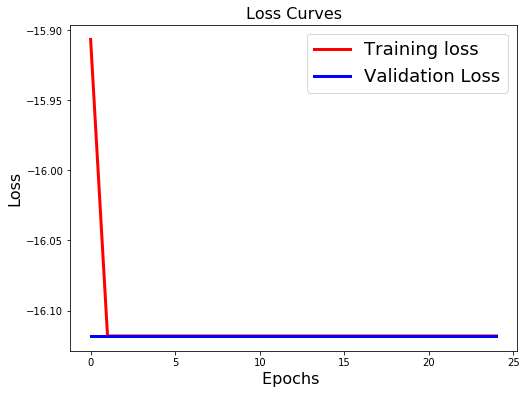

In [19]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['loss'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

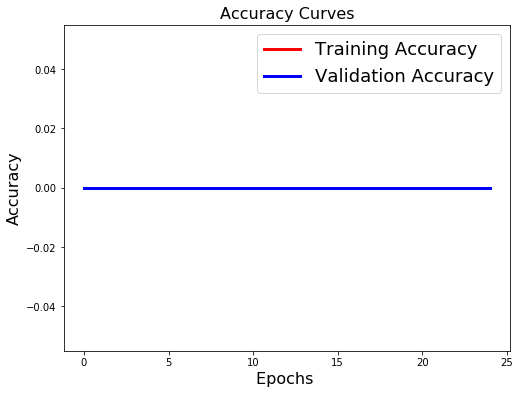

In [20]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['binary_accuracy'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_binary_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [30]:
# Vorhersage generieren
testPredict_100 = model.predict(Xtest_100)

In [26]:
def classification(dataset):
    for i in range(len(dataset)):
        if dataset[i]>= 0.05:
            dataset[i]=1
        elif dataset[i]<= -0.05:
            dataset[i]=-1
        else:
            dataset[i]=0
    return dataset

In [27]:
testPredict_100_C=classification(testPredict_100)

In [28]:
accuracy_score(ytest_100, testPredict_100)

1.0

(array([2., 0., 0., 0., 2., 0., 0., 1., 0., 1.]),
 array([-0.39765787, -0.39361718, -0.38957648, -0.38553579, -0.38149509,
        -0.3774544 , -0.37341371, -0.36937301, -0.36533232, -0.36129162,
        -0.35725093]),
 <a list of 10 Patch objects>)

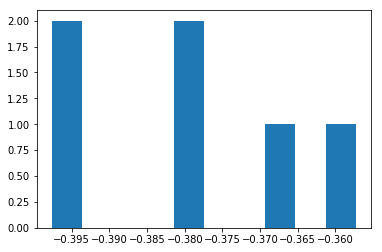

In [31]:
plt.hist(testPredict_100)

(array([0., 0., 0., 0., 0., 6., 0., 0., 0., 0.]),
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5]),
 <a list of 10 Patch objects>)

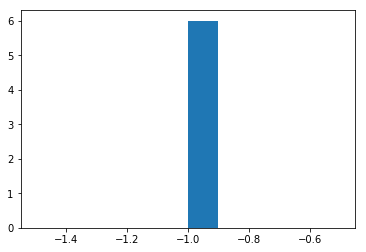

In [32]:
plt.hist(testPredict_100_C)

(array([0., 0., 0., 0., 0., 6., 0., 0., 0., 0.]),
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5]),
 <a list of 10 Patch objects>)

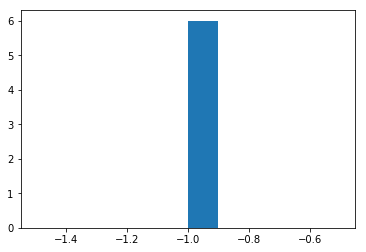

In [33]:
plt.hist(ytest_100)